In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler

In [111]:
dataset = pd.read_csv('dataset.csv', index_col=0)

dataset.head()

,date,symbol,econ_branch,score,year,month,day,close,roi_month,roi_quarter,roi_halfyear,roi_year
0,2004-02-11,SU,Energy Minerals,0.953727,2004,2,11,13.285000,0.015807,-0.085058,0.048927,0.406473
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,2,11,9.388889,-0.048047,-0.010888,0.087811,0.348402
2,2004-02-11,CWT,Utilities,0.934181,2004,2,11,14.720000,-0.002717,-0.068954,-0.070992,0.178668
3,2004-02-11,BLL,Process Industries,0.922862,2004,2,11,8.095000,0.006640,-0.023935,0.124923,0.361334
4,2004-02-11,APA,Energy Minerals,0.912117,2004,2,11,39.830002,0.008034,0.025860,0.082350,0.442882


In [112]:
dataset_prices = dataset
for roi in ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year']:
    dataset_prices['price_'+roi[4:]] = dataset_prices['close']*(dataset_prices[roi]+1)
dataset_prices

,date,symbol,econ_branch,score,year,month,day,close,roi_month,roi_quarter,roi_halfyear,roi_year,price_month,price_quarter,price_halfyear,price_year
0,2004-02-11,SU,Energy Minerals,0.953727,2004,2,11,13.285000,0.015807,-0.085058,0.048927,0.406473,13.495000,12.155000,13.935000,18.684999
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,2,11,9.388889,-0.048047,-0.010888,0.087811,0.348402,8.937778,9.286667,10.213333,12.660000
2,2004-02-11,CWT,Utilities,0.934181,2004,2,11,14.720000,-0.002717,-0.068954,-0.070992,0.178668,14.680000,13.705000,13.675000,17.350000
3,2004-02-11,BLL,Process Industries,0.922862,2004,2,11,8.095000,0.006640,-0.023935,0.124923,0.361334,8.148750,7.901250,9.106250,11.020000
4,2004-02-11,APA,Energy Minerals,0.912117,2004,2,11,39.830002,0.008034,0.025860,0.082350,0.442882,40.150002,40.860001,43.110001,57.470001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,2021-04-07,RPM,Process Industries,0.657795,2021,4,7,90.209999,0.080479,0.007538,-0.115397,-0.042013,97.470001,90.889999,79.800003,86.419998
10406,2021-04-07,AZO,Retail Trade,0.651998,2021,4,7,1423.270020,0.058970,0.088543,0.183001,0.514533,1507.199951,1549.290039,1683.729980,2155.590088
10407,2021-04-07,QRVO,Electronic Technology,0.650983,2021,4,7,193.690002,-0.049099,-0.008725,-0.146420,-0.409830,184.179993,192.000000,165.330002,114.309998
10408,2021-04-07,PHM,Consumer Durables,0.646593,2021,4,7,53.529999,0.153185,0.029516,-0.109658,-0.248085,61.730000,55.110001,47.660000,40.250000


In [113]:
X = dataset[['score', 'symbol', 'close', 'year', 'month', 'day', 'econ_branch']]
y = dataset_prices.iloc[:, -8:]

In [114]:
X.columns, y.columns, X.shape, y.shape

(Index(['score', 'symbol', 'close', 'year', 'month', 'day', 'econ_branch'], dtype='object'),
 Index(['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year', 'price_month',
        'price_quarter', 'price_halfyear', 'price_year'],
       dtype='object'),
 (10410, 7),
 (10410, 8))

In [115]:
dummies1 = pd.get_dummies(X[['econ_branch']], drop_first=True)
dummies2 = pd.get_dummies(X[['symbol']], drop_first=True)
X = pd.concat([X.drop(['econ_branch'],axis=1), dummies1],axis=1)
X = pd.concat([X.drop(['symbol'],axis=1), dummies2],axis=1)
X.shape

(10410, 1149)

In [116]:
y

,roi_month,roi_quarter,roi_halfyear,roi_year,price_month,price_quarter,price_halfyear,price_year
0,0.015807,-0.085058,0.048927,0.406473,13.495000,12.155000,13.935000,18.684999
1,-0.048047,-0.010888,0.087811,0.348402,8.937778,9.286667,10.213333,12.660000
2,-0.002717,-0.068954,-0.070992,0.178668,14.680000,13.705000,13.675000,17.350000
3,0.006640,-0.023935,0.124923,0.361334,8.148750,7.901250,9.106250,11.020000
4,0.008034,0.025860,0.082350,0.442882,40.150002,40.860001,43.110001,57.470001
...,...,...,...,...,...,...,...,...
10405,0.080479,0.007538,-0.115397,-0.042013,97.470001,90.889999,79.800003,86.419998
10406,0.058970,0.088543,0.183001,0.514533,1507.199951,1549.290039,1683.729980,2155.590088
10407,-0.049099,-0.008725,-0.146420,-0.409830,184.179993,192.000000,165.330002,114.309998
10408,0.153185,0.029516,-0.109658,-0.248085,61.730000,55.110001,47.660000,40.250000


We split the data into train and test with proportions 0.67 - 0.33

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

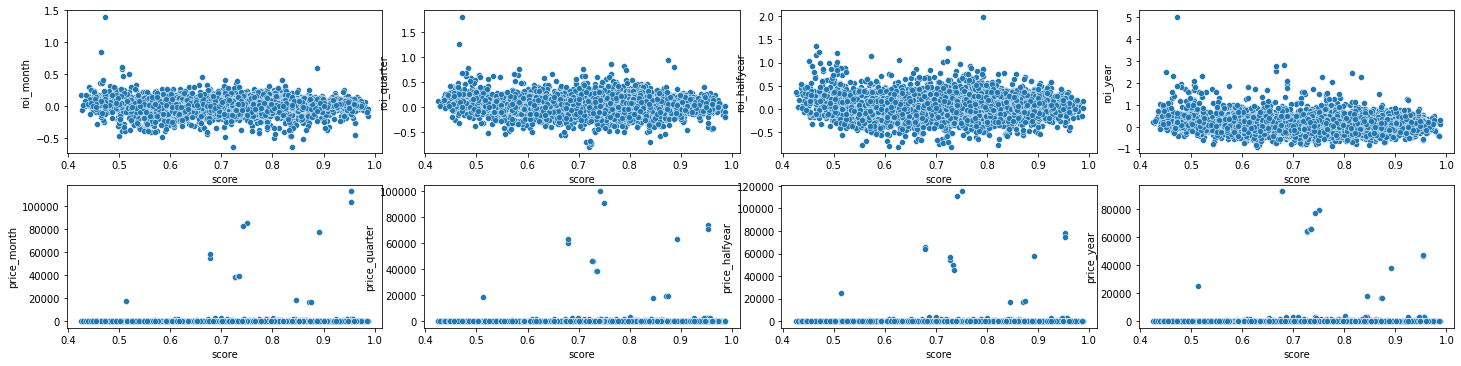

In [118]:
fig, axs = plt.subplots(2, 4, figsize=(20, 5))
fig.tight_layout()
for col_id, roi in enumerate(y.columns):
    sn.scatterplot(ax=axs[col_id//4, col_id%4], x=X_train.score, y=y_train[roi])

In [119]:
X["const"] = 1.0
X

,score,close,year,month,day,econ_branch_Communications,econ_branch_Consumer Durables,econ_branch_Consumer Non-Durables,econ_branch_Consumer Services,econ_branch_Distribution Services,...,symbol_XEL,symbol_XLNX,symbol_XOM,symbol_XRAY,symbol_XRX,symbol_XYL,symbol_YUM,symbol_ZD,symbol_ZTS,const
0,0.953727,13.285000,2004,2,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0.952753,9.388889,2004,2,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0.934181,14.720000,2004,2,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0.922862,8.095000,2004,2,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0.912117,39.830002,2004,2,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,0.657795,90.209999,2021,4,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
10406,0.651998,1423.270020,2021,4,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
10407,0.650983,193.690002,2021,4,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
10408,0.646593,53.529999,2021,4,7,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [120]:
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

for roi in y.columns:
    ols_data = X
    ols_data["roi"] = y[roi]
    model = smf.ols('roi ~ score + close + year', data=ols_data).fit()
    names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
    test = sms.het_breuschpagan(model.resid, model.model.exog)

    print(test)
print(names)

(136.8577611724773, 1.798575997317748e-29, 46.20922627347732, 1.1728770262401472e-29)
(69.10347564178464, 6.640710819337497e-15, 23.179510784665492, 5.99628234194038e-15)
(140.6569570495461, 2.7277581955180644e-30, 47.50957255123, 1.7350253033513322e-30)
(110.84716726797807, 7.211275514558168e-24, 37.332378734578754, 5.472051878603403e-24)
(5631.893610043069, 0.0, 4088.473558569188, 0.0)
(6240.448350159755, 0.0, 5191.453900824924, 0.0)
(6844.334366987354, 0.0, 6658.143785128699, 0.0)
(7204.921363046706, 0.0, 7797.4594070213625, 0.0)
['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']


All p-values are well below 0.05, data isn't homoscedastic for any investment horizon

In [121]:
y_train

,roi_month,roi_quarter,roi_halfyear,roi_year,price_month,price_quarter,price_halfyear,price_year
3033,0.008192,-0.015862,0.079310,0.221022,57.840000,56.459999,61.919998,70.050003
8734,-0.044041,0.126943,0.093523,0.273057,36.900002,43.500000,42.209999,49.139999
4049,0.007254,0.077720,0.104663,0.006477,38.880001,41.599998,42.639999,38.849998
7283,0.004914,-0.008980,-0.027279,-0.225178,59.310001,58.490002,57.410000,45.730000
5265,-0.037806,-0.105114,-0.107080,-0.090253,44.029999,40.950001,40.860001,41.630001
...,...,...,...,...,...,...,...,...
5734,0.039870,0.094914,-0.023964,0.210339,99.370003,104.629997,93.269997,115.660004
5191,0.043577,0.055833,-0.064458,-0.137994,45.980000,46.520000,41.220001,37.980000
5390,0.085159,0.169285,0.255064,0.247830,52.500000,56.570000,60.720001,60.369999
860,-0.039411,-0.042682,-0.031889,-0.102208,14.685000,14.635000,14.800000,13.725000


In [122]:
X_train.shape, y_train.shape

((6974, 1149), (6974, 8))

In [123]:
#https://towardsdatascience.com/how-to-convert-pandas-dataframe-to-keras-rnn-and-back-to-pandas-for-multivariate-regression-dcc34c991df9

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator

In [124]:
y_cols = ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year',
          'price_month', 'price_quarter', 'price_halfyear', 'price_year'
        ]
y_chosen = 'price_year'
y_train_data = y_train[[y_chosen]]
y_test_data = y_test[[y_chosen]]

y_train_data.shape, y_test_data.shape

((6974, 1), (3436, 1))

In [125]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
scaled_X_test = Xscaler.transform(X_test)

Yscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Yscaler.fit(y_train_data)
scaled_y_train = Yscaler.transform(y_train_data)

In [126]:
input_size = 50

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=input_size, batch_size=32)

generator[0][0].shape

(32, 50, 1149)

In [127]:
n_features= X_train.shape[1]


model = keras.Sequential()
model.add(layers.LSTM(20, activation='relu', input_shape=(input_size, n_features)))
# model.add(layers.Dense(100))
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20)                93600     
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 93,621
Trainable params: 93,621
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(generator,epochs=5)

Epoch 1/5
217/217 [==============================] - 41s 186ms/step - loss: 9.5259e-04
Epoch 2/5
217/217 [==============================] - 40s 186ms/step - loss: 8.9473e-04
Epoch 3/5
217/217 [==============================] - 42s 194ms/step - loss: 8.7844e-04
Epoch 4/5
217/217 [==============================] - 41s 188ms/step - loss: 8.6132e-04
Epoch 5/5
217/217 [==============================] - 42s 194ms/step - loss: 8.3990e-04


In [129]:
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=input_size, batch_size=32)
y_pred_scaled = model.predict(test_generator)

106/106 [==============================] - 4s 33ms/step


In [130]:
y_test_data.shape, y_pred_scaled.shape, len(test_generator), "106*32 = "+str(106*32), "3386 < 3392 < 3436"

((3436, 1), (3386, 1), 106, '106*32 = 3392', '3386 < 3392 < 3436')

Remove last 50 observations from scaled_X_test

In [131]:
y_test_data = y_test_data[:-50]
y_test_data.shape, y_pred_scaled.shape

((3386, 1), (3386, 1))

In [132]:
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [133]:
results = pd.DataFrame({'y_true':y_test_data[y_chosen],'y_hat':y_pred.ravel()})

In [134]:
results

,y_true,y_hat
3952,32.349998,-186.966019
4597,37.400002,-282.507446
9624,12.439024,-466.364166
6871,94.790001,-329.386749
4294,33.610001,-151.620193
...,...,...
9290,167.289993,191.112045
5205,26.000000,-84.659622
4419,48.099998,86.072342
188,45.549999,-275.299652


In [135]:
print("1. Mean squared error: %.2f" % mean_squared_error(results["y_true"], results["y_hat"]))
print("2. Mean absolute percentage error: %.2f" % mean_absolute_percentage_error(results["y_true"], results["y_hat"]))
print("3. R^2: %.2f" % r2_score(results["y_true"], results["y_hat"]))

1. Mean squared error: 7691297.20
2. Mean absolute percentage error: 34.10
3. R^2: -0.06


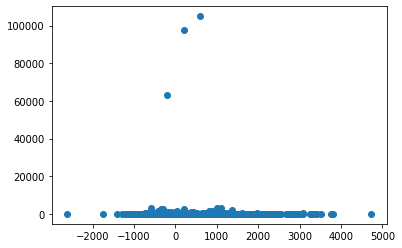

In [136]:
plt.scatter(results["y_hat"], results["y_true"])

In [137]:
def train_evaluate_rnn_model(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame, epochs=5, nn_input_size=50, batch_size=32, chosen_y='price_year'):
    
    y_chosen = chosen_y
    y_train = y_train[[y_chosen]]
    y_test = y_test[[y_chosen]]
    y_test = y_test[:-50]
    Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
    Xscaler.fit(X_train)
    scaled_X_train = Xscaler.transform(X_train)
    scaled_X_test = Xscaler.transform(X_test)

    Yscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that y data is also in 0, 1 range
    Yscaler.fit(y_train)
    scaled_y_train = Yscaler.transform(y_train)

    generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=nn_input_size, batch_size=batch_size)

    model.fit(generator,epochs=epochs)
    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=input_size, batch_size=32)
    y_pred_scaled = model.predict(test_generator)
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    print(y_pred, y_test)
    errors_report = ["1. Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)]
    errors_report.append("2. Mean absolute percentage error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))
    errors_report.append("3. R^2: %.2f" % r2_score(y_test, y_pred))
    print(errors_report)
    return errors_report, y_pred, y_test

In [138]:
y_train, y_test

(      roi_month  roi_quarter  roi_halfyear  roi_year  price_month  \
 3033   0.008192    -0.015862      0.079310  0.221022    57.840000   
 8734  -0.044041     0.126943      0.093523  0.273057    36.900002   
 4049   0.007254     0.077720      0.104663  0.006477    38.880001   
 7283   0.004914    -0.008980     -0.027279 -0.225178    59.310001   
 5265  -0.037806    -0.105114     -0.107080 -0.090253    44.029999   
 ...         ...          ...           ...       ...          ...   
 5734   0.039870     0.094914     -0.023964  0.210339    99.370003   
 5191   0.043577     0.055833     -0.064458 -0.137994    45.980000   
 5390   0.085159     0.169285      0.255064  0.247830    52.500000   
 860   -0.039411    -0.042682     -0.031889 -0.102208    14.685000   
 7270  -0.050170    -0.089286     -0.057540  0.048753    33.509998   
 
       price_quarter  price_halfyear  price_year  
 3033      56.459999       61.919998   70.050003  
 8734      43.500000       42.209999   49.139999  
 4049

In [162]:
n_features= X_train.shape[1]


model = keras.Sequential()
model.add(layers.LSTM(10, activation='relu', input_shape=(input_size, n_features)))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

errors_report, y_pred, y_test = train_evaluate_rnn_model(model, X_train, X_test, y_train, y_test, epochs=5)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10)                46400     
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 46,411
Trainable params: 46,411
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
131/217 [=================>............] - ETA: 2:03 - loss: 9.3957e-04

KeyboardInterrupt: 

<AxesSubplot:>

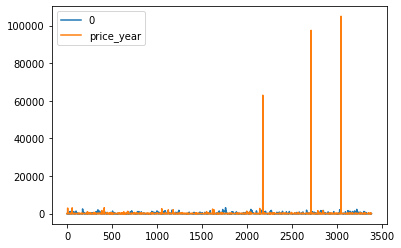

In [161]:
pd.concat((pd.DataFrame(y_pred), y_test.reset_index().drop("index", axis=1)), axis=1).plot()